# Feed-Forward Neural Network
This notebook uses a basic (feed-forward) artificial network to predict presence/absence of beetles in raster cells.

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.layers import Activation, BatchNormalization, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from pprint import pprint
from pylab import *
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve 
from sklearn.preprocessing import StandardScaler

sys.path.append('../')
import data_manipulations as manip

%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 8
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
DATA_PATH =  '../../data/cluster/random/'
os.listdir(DATA_PATH)

['weights.bestNN.hdf5',
 'X_test.csv',
 'X_train.csv',
 'X_train.csv.zip',
 'X_valid.csv',
 'y_test.csv',
 'y_train.csv',
 'y_valid.csv']

In [3]:
def load_data(data_dir):
    X_train = pd.read_csv(data_dir + 'X_train.csv')
    print('X_train:', X_train.shape)
    X_valid = pd.read_csv(data_dir + 'X_valid.csv')
    print('X_valid:', X_valid.shape)
    X_test  = pd.read_csv(data_dir + 'X_test.csv')
    print('X_test:',  X_test.shape)
    y_train = pd.read_csv(data_dir + 'y_train.csv')
    print('y_train:', y_train.shape)
    y_valid = pd.read_csv(data_dir + 'y_valid.csv')
    print('y_valid:', y_valid.shape)
    y_test  = pd.read_csv(data_dir + 'y_test.csv')
    print('y_test:',  y_test.shape)
    
    return [[X_train, y_train], [X_valid, y_valid], [X_test, y_test]]

In [4]:
[[X_train, y_train], [X_valid, y_valid], [X_test, y_test]] = load_data(
    DATA_PATH)

X_train: (617893, 24)
X_valid: (132406, 24)
X_test: (132406, 24)
y_train: (617893, 1)
y_valid: (132406, 1)
y_test: (132406, 1)


In [5]:
list(X_train)

['year',
 'meanTemp_Annual',
 'meanTemp_AprAug',
 'meanTemp_Aug',
 'meanMinTemp_DecFeb',
 'meanMinTemp_Oct',
 'meanMinTemp_Jan',
 'meanMinTemp_Mar',
 'meanMaxTemp_Aug',
 'precip_meanAnnual',
 'precip_JunAug',
 'vegetation',
 'precipPrevious_JunAug',
 'precip_OctSep',
 'precipPrevious_OctSep',
 'precip_growingSeason',
 'varPrecip_growingSeason',
 'elev_etopo1',
 'lat',
 'lon',
 'studyArea',
 'elev_srtm30',
 'x',
 'y']

In [6]:
def summarize(df, field, plot=True):
    quantiles = df.quantile(q=[0, 0.25, 0.5, 0.75, 1], axis=0)
    means = df.mean(axis=0)
    
    quants = quantiles[field]
    values = df[field]
    values = values[np.isnan(values) == False]
    n_nan  = values[np.isnan(values) == True].sum()
    is_finite = np.isfinite(values).all()

    print('\n%s:\n%10s%10s%10s%10s%10s%10s\n'
          '%10.2f%10.2f%10.2f%10.2f%10.2f%10.2f'
          % (field, 'min', '25%', 'med', 'mean', '75%', 'max',
             quants[0], quants[0.25], quants[0.5], means[field], 
             quants[0.75], quants[1]))
    if plot:
        plt.figure();
        plt.hist(values);
        plt.title(field);

In [7]:
#ignore = ['x', 'y', 'year']
#for field in list(X_train):
    #if field not in ignore:
        #summarize(X_train, field, plot=False)
        #summarize(X_valid, field, plot=False)
        #summarize(X_test,  field, plot=False)

In [8]:
#for YEAR in range(2000, 2015):
#    plt.figure()
#    plt.scatter(
#        X_train.loc[(y_train['beetle'] == 1) & (X_train['year'] == YEAR), 
#                    'lon'], 
#        X_train.loc[(y_train['beetle'] == 1) & (X_train['year'] == YEAR), 
#                    'lat'],
#        alpha=0.1, label=YEAR);
#    plt.legend(loc='best');

In [9]:
y_train.head()

,beetle
0,0
1,0
2,0
3,0
4,0


In [10]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['studyArea', 'x', 'y', 'year'], axis=1)
X_valid = X_valid.drop(['studyArea', 'x', 'y', 'year'], axis=1)
X_test  = X_test.drop(['studyArea', 'x', 'y', 'year'],  axis=1)

In [11]:
np.isfinite(X_train).all()

meanTemp_Annual             True
meanTemp_AprAug             True
meanTemp_Aug                True
meanMinTemp_DecFeb          True
meanMinTemp_Oct             True
meanMinTemp_Jan             True
meanMinTemp_Mar             True
meanMaxTemp_Aug             True
precip_meanAnnual           True
precip_JunAug               True
vegetation                  True
precipPrevious_JunAug       True
precip_OctSep               True
precipPrevious_OctSep       True
precip_growingSeason        True
varPrecip_growingSeason    False
elev_etopo1                 True
lat                         True
lon                         True
elev_srtm30                 True
dtype: bool

In [12]:
print('X_train:', 
      np.isnan(X_train.varPrecip_growingSeason).sum() / X_train.shape[0])
print('X_valid:', 
      np.isnan(X_valid.varPrecip_growingSeason).sum() / X_valid.shape[0])
print('X_test:',  
      np.isnan(X_test.varPrecip_growingSeason).sum() / X_test.shape[0])

X_train: 0.00478076301237
X_valid: 0.00493180067369
X_test: 0.00518858661994


In [13]:
# NaNs in less than 1% of the rows.... just drop
def drop_nans(X_df, y_df, field, verbose=True):
    X = X_df.copy()
    y = y_df.copy()
    X = X.loc[np.isnan(X_df[field]) == False, :]
    y = y.loc[np.isnan(X_df[field]) == False, :]
    
    if verbose:
        print(X.shape, y.shape)
    return X, y


X_train, y_train = drop_nans(X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = drop_nans(X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = drop_nans(X_test,  y_test,  'varPrecip_growingSeason')

(614939, 20) (614939, 1)
(131753, 20) (131753, 1)
(131719, 20) (131719, 1)


In [14]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [15]:
def vectorize(y):
    y = y.tolist()
    for i in range(len(y)):
        y[i] = [1, 0] if y[i] == [0] else [0, 1]
        
    return np.array(y)

In [16]:
y_train = y_train.as_matrix()
y_valid = y_valid.as_matrix()
y_test  = y_test.as_matrix()

In [17]:
y_train = vectorize(y_train)
y_valid = vectorize(y_valid)
y_test  = vectorize(y_test)

# Neural Net Model

In [18]:
best_val_loss = np.inf
X_train.shape

(614939, 20)

In [24]:
# Params and Hyperparams
n_inputs = X_train.shape[1]
n_outputs = 2

# Current best
N_LAYERS = 16
#NODES_PER_LAYER = ([n_inputs] * N_LAYERS)
NODES_PER_LAYER = [
    n_inputs, n_inputs * 2, n_inputs * 4, n_inputs * 4, n_inputs *2, 
    n_inputs]
NODES_PER_LAYER.append(n_outputs)
ETA = 0.1
DROPOUT = 0    
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-08
DECAY = 0.01
EPOCHS = 124
BATCH_SIZE = 1024

NODES_PER_LAYER

[20, 40, 80, 80, 40, 20, 2]

In [25]:
def get_params():
    return {'NODES_PER_LAYER': NODES_PER_LAYER,
            'ETA': ETA,
            'DROPOUT': DROPOUT,
            'BETA_1': BETA_1,
            'BETA_2': BETA_2,
            'EPSILON': EPSILON,
            'DECAY': DECAY,
            'EPOCHS': EPOCHS,
            'BATCH_SIZE': BATCH_SIZE}

In [26]:
model = Sequential()

# NOTE: "glorot-normal" is the same thing as "Xavier" initialization
model.add(Dense(NODES_PER_LAYER[1], 
                input_dim=NODES_PER_LAYER[0], 
                kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

# additional hidden layers here
for i in range(2, len(NODES_PER_LAYER) - 1):
    model.add(Dense(NODES_PER_LAYER[i], 
                    kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))

model.add(Dense(NODES_PER_LAYER[-1], kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 40)                840       
_________________________________________________________________
batch_normalization_7 (Batch (None, 40)                160       
_________________________________________________________________
activation_7 (Activation)    (None, 40)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 80)                3280      
_________________________________________________________________
batch_normalization_8 (Batch (None, 80)                320       
_________________________________________________________________
activation_8 (Activation)    (None, 80)                0         
__________

In [27]:
adam = Adam(
    lr=ETA, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON, decay=DECAY)
model.compile(
    loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [28]:
VERBOSE = 1
checkpointer = ModelCheckpoint(filepath=DATA_PATH + 'weights.bestNN.hdf5',
                               verbose=VERBOSE,
                               save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=20)
start = time.time()
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpointer, earlyStop],
                    verbose=VERBOSE)
elapsed = time.time() - start

Train on 614939 samples, validate on 131753 samples
Epoch 1/124
614939/614939 [==============================] - 19s 31us/step - loss: 0.2240 - acc: 0.8979 - val_loss: 0.2082 - val_acc: 0.9051
Epoch 2/124
614939/614939 [==============================] - 15s 25us/step - loss: 0.2020 - acc: 0.9085 - val_loss: 0.2016 - val_acc: 0.9090
Epoch 3/124
614939/614939 [==============================] - 15s 25us/step - loss: 0.1950 - acc: 0.9119 - val_loss: 0.1926 - val_acc: 0.9134
Epoch 4/124
614939/614939 [==============================] - 15s 25us/step - loss: 0.1900 - acc: 0.9146 - val_loss: 0.1903 - val_acc: 0.9147
Epoch 5/124
614939/614939 [==============================] - 15s 25us/step - loss: 0.1857 - acc: 0.9168 - val_loss: 0.1845 - val_acc: 0.9169
Epoch 6/124
614939/614939 [==============================] - 15s 25us/step - loss: 0.1823 - acc: 0.9187 - val_loss: 0.1818 - val_acc: 0.9188
Epoch 7/124
614939/614939 [==============================] - 15s 25us/step - loss: 0.1799 - acc: 0.919

In [29]:
print('Time: %.2f minutes' % (elapsed / 60))

Time: 34.66 minutes


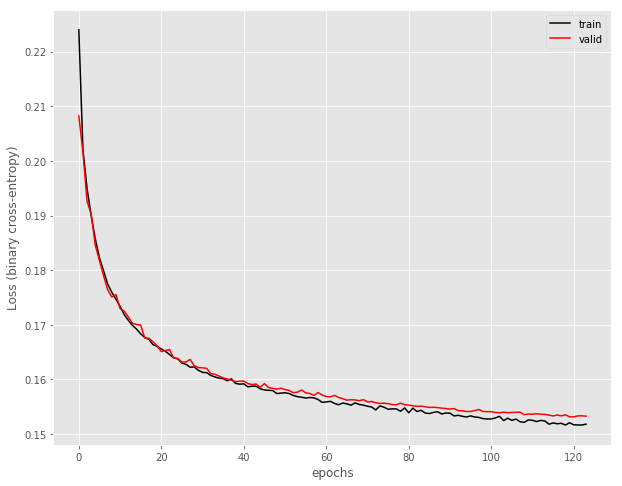

In [30]:
plt.plot(history.history['loss'], 'k-', label='train');
plt.plot(history.history['val_loss'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Loss (binary cross-entropy)')
#plt.yscale('log');
plt.legend(loc='best');

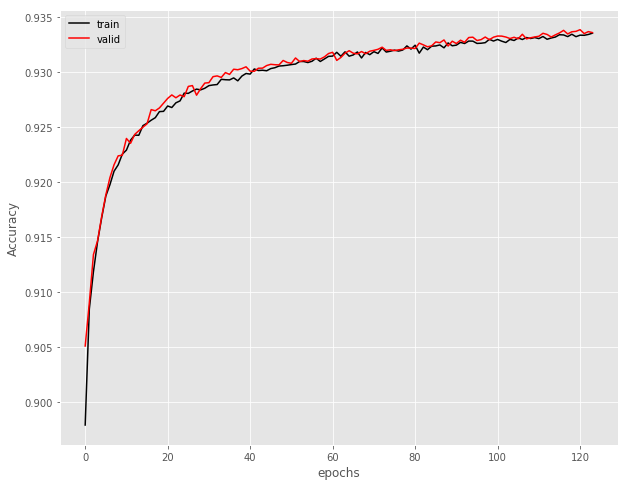

In [31]:
plt.plot(history.history['acc'], 'k-', label='train');
plt.plot(history.history['val_acc'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Accuracy')
#plt.yscale('log');
plt.legend(loc='best');

In [32]:
this_run = np.mean(history.history['val_loss'][-50:])
print('This run: %.5f' % this_run)

This run: 0.15426


In [33]:
if this_run < best_val_loss:
    print('New Best Model Found!\n')
    best_val_loss = this_run
    train_loss_of_best = np.mean(history.history['loss'][-50:])
    best_params = get_params()
print('Best validation loss so far: %.5f' % best_val_loss)
print('Training loss of same model: %.5f' % train_loss_of_best)
print('Best hyperparameters found so far:')

New Best Model Found!

Best validation loss so far: 0.15426
Training loss of same model: 0.15310
Best hyperparameters found so far:


In [34]:
pprint(best_params)

{'BATCH_SIZE': 1024,
 'BETA_1': 0.9,
 'BETA_2': 0.999,
 'DECAY': 0.01,
 'DROPOUT': 0,
 'EPOCHS': 124,
 'EPSILON': 1e-08,
 'ETA': 0.1,
 'NODES_PER_LAYER': [20, 40, 80, 80, 40, 20, 2]}


# Check Performance Against Test Set

In [35]:
preds = model.predict(X_test)

In [36]:
print(preds[:10])
print(y_test[:10])

[[  9.91120636e-01   8.87943897e-03]
 [  9.99965787e-01   3.41764571e-05]
 [  9.99916077e-01   8.39519198e-05]
 [  9.71896291e-01   2.81036608e-02]
 [  1.69149324e-01   8.30850661e-01]
 [  9.99942183e-01   5.77775754e-05]
 [  7.91255236e-01   2.08744794e-01]
 [  9.81336892e-01   1.86631717e-02]
 [  8.51366818e-02   9.14863348e-01]
 [  9.99653459e-01   3.46568675e-04]]
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


In [37]:
def preds2probs(preds):
    return [pred[1] for pred in preds]

In [38]:
pred_probs = preds2probs(preds)
pred_probs[:10]

[0.008879439,
 3.4176457e-05,
 8.395192e-05,
 0.028103661,
 0.83085066,
 5.7777575e-05,
 0.20874479,
 0.018663172,
 0.91486335,
 0.00034656868]

In [39]:
def binarize(preds):
    return [[round(x) for x in p] for p in preds]

def one_cold(one_hot_matrix):
    # [[0, 1], [0, 1], [1, 0]] -> [1, 1, 0]
    return [argmax(vector) for vector in one_hot_matrix]

In [40]:
preds = one_cold(binarize(preds))
y_test = one_cold((y_test))

print(preds[:10])
print(y_test[:10])
#print(np.array(preds).sum())
#print(y_test.sum())

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [41]:
def print_cm(tp, tn, fp, fn):
    print('Confusion Matrix:')
    print('         Predicted:')
    print('         \t1\t\t0')
    print('Actual: 1\t%d\t\t%d' %(tp, fn))
    print('        0\t%d\t\t%d' %(fp, tn))

In [42]:
pred = np.array([0, 0, 1, 1])
target = np.array([0, 1, 0, 1])
print('true pos: ', (pred & target))
print('true neg: ', 1 * (np.logical_not(pred) & np.logical_not(target)))
print('false pos:', 1 * (pred & np.logical_not(target)))
print('false neg:', 1 * (np.logical_not(pred) & target))

true pos:  [0 0 0 1]
true neg:  [1 0 0 0]
false pos: [0 0 1 0]
false neg: [0 1 0 0]


In [43]:
def make_confusion_matrix(targets, pred_probs, threshold, verbose=True):
    targets = np.array(targets)
    pred_probs = np.array(pred_probs)
    preds = 1 * (pred_probs >= threshold)
    
    #preds_binary = binarize(preds)
    tp = sum(preds & targets)
    tn = sum(np.logical_not(preds) & np.logical_not(targets))
    fp = sum(preds & np.logical_not(targets))
    fn = sum(np.logical_not(preds) & targets)
    
    if verbose:
        print_cm(tp, tn, fp, fn)

    return {'tp': tp, 'fp': fp,'tn': tn, 'fn': fn}

In [44]:
print(y_test[:10])
print(pred_probs[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.008879439, 3.4176457e-05, 8.395192e-05, 0.028103661, 0.83085066, 5.7777575e-05, 0.20874479, 0.018663172, 0.91486335, 0.00034656868]


In [45]:
cm = make_confusion_matrix(y_test, pred_probs, 0.5)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	16097		4690
        0	3945		106987


In [46]:
def get_metrics(cm):
    accuracy  = ((cm['tp'] + cm['tn']) /
                 (cm['tp'] + cm['tn'] + cm['fp'] + cm['fn']))
    precision = cm['tp'] / (cm['tp'] + cm['fp'])
    recall    = cm['tp'] / (cm['tp'] + cm['fn'])
    F         = 2 * precision * recall / (precision + recall)

    print('Accuracy: ', accuracy)
    print('Precision:', precision)
    print('Recall:   ', recall)
    print('F1:       ', F)

In [47]:
metrics = get_metrics(cm)

Accuracy:  0.934443778043
Precision: 0.80316335695
Recall:    0.774378217155
F1:        0.788508168214


In [48]:
def get_auc(target, preds):
    fpr, tpr, _ = roc_curve(target, preds)
    mod_auc = auc(fpr, tpr)
    print('AUC:      ', mod_auc)

    return { 'fpr': fpr, 'tpr': tpr, 'auc': mod_auc }

In [49]:
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, 'k')
    plt.plot([0, 1], [0, 1], 'r')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    plt.show()

In [50]:
auc_metrics = get_auc(y_test, pred_probs)
auc_metrics['fpr']

AUC:       0.973070993747


array([  0.00000000e+00,   0.00000000e+00,   9.01453142e-06, ...,
         9.95645981e-01,   9.95664010e-01,   1.00000000e+00])

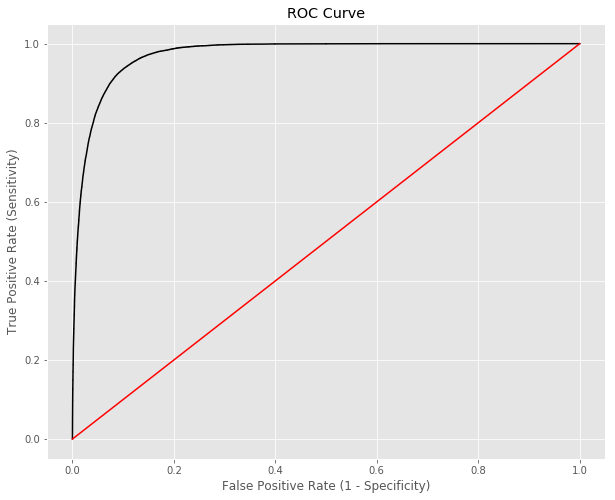

In [51]:
plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])